In [165]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import collections
import numpy as np
from fuzzywuzzy import fuzz
%matplotlib inline

In [ ]:
# This code is all data-specific, but instructions are given later on how
# later code can be generalized. It may be quite difficult in practice.
# The point where code becomes generalizable is well-marked.

In [166]:
# This code reads in the graph constructed using DBpedia
phil_graph = nx.Graph()

In [167]:
# Populate nodes
with open('/afs/inf.ed.ac.uk/user/s16/s1681453/data_justin/stn_phil_list2.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # Skip the header
    for row in reader:
        phil_graph.add_node(row[0], name=row[2])

In [168]:
# Populate edges
with open('/afs/inf.ed.ac.uk/user/s16/s1681453/data_justin/stn_phil_edges.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # Skip the header
    phil_graph.add_edges_from(reader)

In [169]:
# Aids in identifying communities
names_to_nodes = {}
for n, d in phil_graph.nodes_iter(data=True):
    l = d['name']
    names_to_nodes[l] = n

In [170]:
# Identify communities; I used this query on DBpedia to build the 
# list of philosophers and their communities:
# select ?interest ?name where {
# ?phil a <http://dbpedia.org/ontology/Philosopher>.
# ?phil <http://dbpedia.org/ontology/mainInterest> ?interest.
# ?phil <http://dbpedia.org/property/name> ?name.
# } order by ?interest
communities = {}
with open('/afs/inf.ed.ac.uk/user/s16/s1681453/data_justin/Main_Interests.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[1] in names_to_nodes:
            if row[0] in communities:
                communities[row[0]].append(names_to_nodes[row[1]])
            else:
                communities[row[0]] = []
                communities[row[0]].append(names_to_nodes[row[1]])  

In [171]:
def biggest_connected_component(subgraph):
    gen = nx.connected_component_subgraphs(subgraph)
    max_size = 0
    biggest_comp = nx.Graph()
    for next_graph in gen:
        if next_graph.number_of_nodes() > max_size:
            biggest_comp = next_graph
            max_size = next_graph.number_of_nodes()
    return biggest_comp

In [197]:
communities_connected_pruned = {interest:biggest_connected_component(
                                phil_graph.subgraph(phil)) 
                                for (interest, phil) 
                                in communities.items() 
                                if biggest_connected_component(
                    phil_graph.subgraph(phil)).number_of_nodes() > 7}

In [173]:
for x in communities_connected_pruned:
    print(x, len(communities_connected_pruned[x]))

http://dbpedia.org/resource/Logic 22
http://dbpedia.org/resource/Ethics 48
http://dbpedia.org/resource/Epistemology 66
http://dbpedia.org/resource/Political_philosophy 49
http://dbpedia.org/resource/Philosophy_of_mind 27
http://dbpedia.org/resource/Politics 12
http://dbpedia.org/resource/Physics 8
http://dbpedia.org/resource/Metaphysics 61
http://dbpedia.org/resource/Aesthetics 27
http://dbpedia.org/resource/Philosophy_of_language 32
http://dbpedia.org/resource/Philosophy_of_science 29
http://dbpedia.org/resource/Ontology 21
http://dbpedia.org/resource/Philosophy_of_mathematics 13


/Users/justinpayan/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


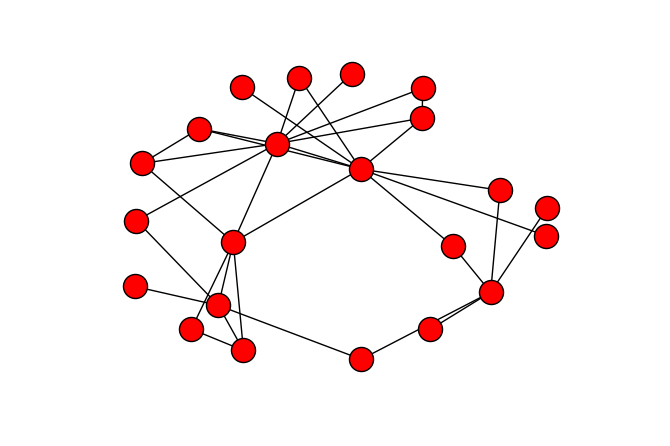

In [174]:
nx.draw(communities_connected_pruned['http://dbpedia.org/resource/Logic'])

In [175]:
# Now we read in the graph from Web of Science
citation_graph = nx.read_gpickle('/afs/inf.ed.ac.uk/user/s16/s1681453/data_justin/bipartite_pickle.pickle')

In [198]:
print(citation_graph.number_of_nodes())
print(citation_graph.number_of_edges())
print(phil_graph.number_of_nodes())
print(phil_graph.number_of_edges())

# Number of canonical philosophers in the citation network
print(len([x for x in citation_graph.node if 
           citation_graph.node[x]['bipartite'] == 1])) 

101083
696923
1530
5546
511


In [202]:
# Past this point, the code may be run with any dataset. Simply replace all 
# instances of "communities_connected_pruned" with a dictionary of communities 
# of your choosing (keys should be labels, and values should be subgraphs relating
# to communities). You will also have to change the phil_graph instances and 
# the citation_graph instances to some other 2 reasonable graphs for your dataset.

# All of the metrics are defined here.
def avg_shortest_path_length_metric(community_1, 
                                    community_2, params):
    total_num_paths = community_1.number_of_nodes()* \
                        community_2.number_of_nodes()
    sum_path_lengths = 0.0
    for x in community_1.nodes():
        for y in community_2.nodes():
            sum_path_lengths = sum_path_lengths + \
            nx.shortest_path_length(phil_graph, x, y)
    return sum_path_lengths / total_num_paths

In [178]:
def max_ICDF_metric(community_1, community_2, params):
    max_deg = max(community_1.degree().values(), 
                  key=lambda y:y)
    icdf_1 = max_deg/community_1.number_of_nodes()
    max_deg = max(community_2.degree().values(), 
                  key=lambda y:y)
    icdf_2 = max_deg/community_2.number_of_nodes()
    return np.abs(icdf_1 - icdf_2)

In [179]:
def rand_sim(x, y, params):
    return(np.random.rand())

In [180]:
def power_law_fit(to_fit):
    """Input a dictionary with x values as keys and y 
    values as values. Outputs the coefficient and 
        exponent of a power law distribution fit.
    """
    log_y_vals = [np.log(y) for x,y in to_fit.items()]
    x_vals = [[1, x] for x in to_fit]
    w_fit = np.linalg.lstsq(x_vals, log_y_vals)[0]
    return np.exp(w_fit[0]), np.exp(w_fit[1])

def temp_pwr_law_sim(x,y,params):
    degrees = [b for a,b in x.degree().items()]
    dist = collections.Counter(degrees)
    fit_1 = power_law_fit(dist)
    
    degrees = [b for a,b in y.degree().items()]
    dist = collections.Counter(degrees)
    fit_2 = power_law_fit(dist)
    return(np.abs(fit_1[1] - fit_2[1]))

In [181]:
# This code is adapted from here: 
# http://stackoverflow.com/questions/12122021/python-
# implementation-of-a-graph-similarity-grading-algorithm
def choose_final(spectrum, min_energy):
    current = 0.0
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        current += spectrum[i]
        if current / total >= min_energy:
            return i + 1
    return len(spectrum)

def spectral_sim(graph1, graph2, params):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)

    k1 = choose_final(laplacian1, 0.9)
    k2 = choose_final(laplacian2, 0.9)
    k = min(k1, k2)

    return sum((laplacian1[:k] - laplacian2[:k])**2)

In [203]:
# For each pair of canonical communities, we compute the 
# similarity as the ratio of the overlap in contemporary 
# philosophers citing them to the total number of 
# contemporary philosophers citing them
def compute_all_overlap_similarities(community_1, 
                                     community_2, parameters):
    canonical_phils_1 = list(
        nx.get_node_attributes(community_1, 'name').values())
    canonical_phils_2 = list(
        nx.get_node_attributes(community_2, 'name').values())
    citing_philosophers_1 = set_of_citers(canonical_phils_1)
    citing_philosophers_2 = set_of_citers(canonical_phils_2)
    return len(citing_philosophers_1 & citing_philosophers_2) / \
            len(citing_philosophers_1 | citing_philosophers_2)


def set_of_citers(canonical_phils):
    citers = set()
    for raw_name in canonical_phils:
        list_name = raw_name.lower().split(' ')
        cleaned_name = list_name[-1]
        for f in list_name[:-1]:
            cleaned_name = cleaned_name + " " + f[0]
        if citation_graph.has_node(cleaned_name):
            citers = citers | set(
                citation_graph.predecessors(cleaned_name))
    return citers

In [204]:
# A generic function that takes in the dictionary of the 
# communities, a list of other parameters needed, and a
# similarity metric, and outputs a dictionary of community 
# name pairs mapped to their similarity metric
def compute_similarities(dict_of_communities, 
                         parameters, sim_metric):
    list_of_topics = list(dict_of_communities.keys())
        
    result = {}
    for topic_1_num in range(len(list_of_topics)):
        for topic_2_num in range(topic_1_num+1, 
                                 len(list_of_topics)):
            result[(list_of_topics[topic_1_num].split("/")[-1], 
                    list_of_topics[topic_2_num].split("/")[-1])] = \
                    sim_metric(dict_of_communities[list_of_topics[topic_1_num]], 
                    dict_of_communities[list_of_topics[topic_2_num]], parameters)
    return result

In [184]:
def normalize_dictionary(dictionary):
    max_val = max(list(dictionary.values()))
    min_val = min(list(dictionary.values()))
    for a in dictionary:
        dictionary[a] = (dictionary[a]-min_val)/(max_val-min_val)

In [185]:
def rmse_two_metrics(metric_1, metric_2):
    sim_1 = compute_similarities(communities_connected_pruned, 
                                 [], metric_1)
    sim_2 = compute_similarities(communities_connected_pruned, 
                                 [], metric_2)
    normalize_dictionary(sim_1)
    normalize_dictionary(sim_2)
    sse = 0.0
    for x,y in sim_1.items():
        sse = sse + (y - sim_2[x])**2
    return np.sqrt(sse / len(sim_1))

In [206]:
def compute_points_with_rules(dict_of_sim_scores):
    groups = (('Epistemology', 
               'Metaphysics', 
               'Philosophy_of_language', 
               'Philosophy_of_mind', 
               'Ontology'),
              
              ('Politics', 
               'Aesthetics', 
               'Political_philosophy', 
               'Ethics'),
              
              ('Logic', 
               'Physics', 
               'Philosophy_of_mathematics', 
               'Philosophy_of_science')
             )
    points = 0
    for topic_1 in groups[0]:
        for topic_2 in groups[0]:
            if (topic_1, topic_2) in dict_of_sim_scores:
                for topic_3 in groups[1]:
                    if (topic_1, topic_3) in dict_of_sim_scores:
                        if dict_of_sim_scores[(topic_1, topic_3)] < \
                        dict_of_sim_scores[(topic_1, topic_2)]:
                            points = points + 1
                    if (topic_3, topic_1) in dict_of_sim_scores:
                        if dict_of_sim_scores[(topic_3, topic_1)] < \
                        dict_of_sim_scores[(topic_1, topic_2)]:
                            points = points + 1
                for topic_3 in groups[2]:
                    if (topic_1, topic_3) in dict_of_sim_scores:
                        if dict_of_sim_scores[(topic_1, topic_3)] < \
                        dict_of_sim_scores[(topic_1, topic_2)]:
                            points = points + 1
                    if (topic_3, topic_1) in dict_of_sim_scores:
                        if dict_of_sim_scores[(topic_3, topic_1)] < \
                        dict_of_sim_scores[(topic_1, topic_2)]:
                            points = points + 1
                            
    for topic_1 in groups[1]:
        for topic_2 in groups[1]:
            if (topic_1, topic_2) in dict_of_sim_scores:
                for topic_3 in groups[2]:
                    if (topic_1, topic_3) in dict_of_sim_scores:
                        if dict_of_sim_scores[(topic_1, topic_3)] < \
                        dict_of_sim_scores[(topic_1, topic_2)]:
                            points = points + 1
                    if (topic_3, topic_1) in dict_of_sim_scores:
                        if dict_of_sim_scores[(topic_3, topic_1)] < \
                        dict_of_sim_scores[(topic_1, topic_2)]:
                            points = points + 1
    return points

The number of possible points is 208.

In [192]:
list_of_sim1 = compute_similarities(communities_connected_pruned, 
                                    [], avg_shortest_path_length_metric)
list_of_sim2 = compute_similarities(communities_connected_pruned, 
                                    [], temp_pwr_law_sim)
list_of_sim3 = compute_similarities(communities_connected_pruned, 
                                    [], rand_sim)
list_of_sim4 = compute_similarities(communities_connected_pruned, 
                                    [], max_ICDF_metric)
list_of_sim5 = compute_similarities(communities_connected_pruned, 
                                    [], compute_all_overlap_similarities)
list_of_sim6 = compute_similarities(communities_connected_pruned, 
                                    [], spectral_sim)

In [193]:
score = []
score.append(compute_points_with_rules(list_of_sim1))
score.append(compute_points_with_rules(list_of_sim2))
score.append(compute_points_with_rules(list_of_sim3))
score.append(compute_points_with_rules(list_of_sim4))
score.append(compute_points_with_rules(list_of_sim5))
score.append(compute_points_with_rules(list_of_sim6))

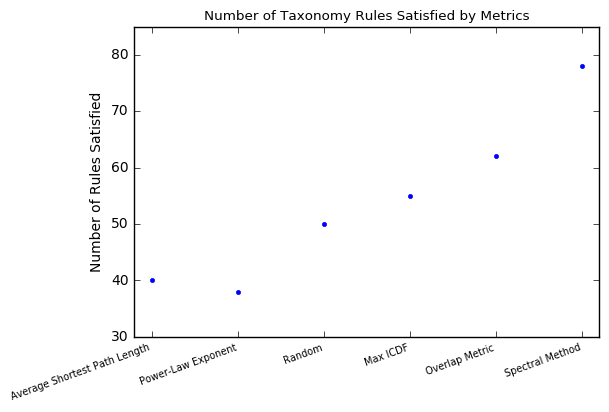

In [213]:
plt.plot(score, '.')
plt.title("Number of Taxonomy Rules Satisfied by Metrics", size=9.7)
plt.ylabel("Number of Rules Satisfied")
plt.xlim([-0.2, 5.2])
plt.ylim([30, 85])
plt.xticks(range(6), ["Average Shortest Path Length", "Power-Law Exponent", 
                         "Random", "Max ICDF", 
                         "Overlap Metric", "Spectral Method"], size=7, rotation=20, ha='right')
#plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("RulesSat.png")

In [190]:
rmse = []
rmse.append(rmse_two_metrics(compute_all_overlap_similarities, 
                             spectral_sim))
rmse.append(rmse_two_metrics(compute_all_overlap_similarities, 
                             max_ICDF_metric))
rmse.append(rmse_two_metrics(compute_all_overlap_similarities, 
                             temp_pwr_law_sim))
rmse.append(rmse_two_metrics(compute_all_overlap_similarities, 
                             avg_shortest_path_length_metric))
rmse.append(rmse_two_metrics(compute_all_overlap_similarities, 
                             rand_sim))

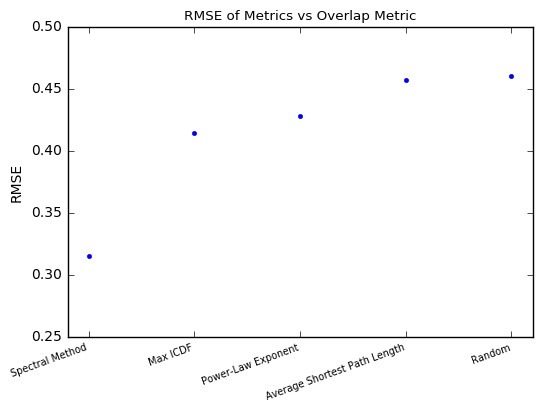

In [214]:
plt.plot(rmse, '.')
plt.title("RMSE of Metrics vs Overlap Metric", size=9.7)
plt.ylabel("RMSE")
plt.xlim([-0.2, 4.2])
plt.ylim([0.25, 0.5])
plt.xticks(range(5), ["Spectral Method", "Max ICDF", "Power-Law Exponent", 
                    "Average Shortest Path Length", "Random"], size=7, rotation=20, ha='right')
#plt.gcf().subplots_adjust(bottom=.35, left=.2, right=.8)
plt.savefig("RMSE.png")